PICASO requires numpy>=1.22.4, but starry requires numpy<=1.21.6
Better to run this notebook in a new environment with PICASO installation
```
!which pip
%pip install virga-exo==0.3.4
%pip install picaso==3.1.2
```

In [1]:
import os
homedir = os.path.expanduser("~")
# Path to picaso reference data
ref = f"{homedir}/workspace/dopplerimg/venv/picaso/reference"
os.environ['picaso_refdata'] = ref
os.environ["PYSYN_CDBS"] = f"{ref}/grp/redcat/trds"
from picaso import justdoit as pj
from virga import justdoit as vj
from picaso import justplotit as picplt
import numpy as np
import pandas as pd
import astropy.units as u
from matplotlib import pyplot as plt

/Users/xqchen/anaconda3/envs/picasoenv/lib/python3.11/site-packages/picaso/justdoit.py:54: UserWarning: Your code version is 3.2.2 but your reference data version is 3.1. For some functionality you may experience Keyword errors. Please download the newest ref version or update your code: https://github.com/natashabatalha/picaso/tree/master/reference
  warnings.warn(f"Your code version is {__version__} but your reference data version is {ref_v}. For some functionality you may experience Keyword errors. Please download the newest ref version or update your code: https://github.com/natashabatalha/picaso/tree/master/reference")


In [2]:
wave_range = [0.6, 6.0]
opafile = f"{homedir}/uoedrive/data/opacity/all_opacities_0.6_6_R60000.db"

opa = pj.opannection(wave_range=wave_range, filename_db=opafile)
#opa = pj.opannection(wave_range=wave_range)

In [3]:
# physcial properties
bd = pj.inputs(calculation='browndwarf')
Teff = 1300
bd.gravity(gravity=1000, gravity_unit=u.Unit('m/s**2'))
bd.phase_angle(0)
metallicity = 1 #atmospheric metallicity relative to Solar
mean_molecular_weight = 2.2 # atmospheric mean molecular weight

In [19]:
# prepare atmosphere pt and chemistry # OR 
ptfile = f"{homedir}/uoedrive/data/diamondback/tp_profiles/t1300g1000nc_m0.0_co1.0.pt"
p_callie, t_callie = np.loadtxt(ptfile, usecols=[1,2], unpack=True, skiprows=2)
bd.add_pt(t_callie, p_callie)
bd.channon_grid_low(filename=os.path.join(os.environ.get('picaso_refdata'),'chemistry','visscher_abunds_m+0.0_co1.0' ))

In [6]:
def convert_unit(spectrum_output, R=1000):
    x, y = spectrum_output['wavenumber'], spectrum_output['thermal'] #units of erg/cm2/s/cm

    xmicron = 1e4/x

    flamy = y*1e-8 #per anstrom instead of per cm
    sp = pj.psyn.ArraySpectrum(xmicron, flamy,
                            waveunits='um',
                            fluxunits='FLAM')
    sp.convert("um")
    sp.convert('Fnu') #erg/cm2/s/Hz

    x = sp.wave #micron
    y = sp.flux #erg/cm2/s/Hz
    spectrum_output['wavelength'] = x
    spectrum_output['fluxnu'] = y
    x, y = pj.mean_regrid(x, y, R=R) # um, erg/cm2/s/Hz
    spectrum_output['regridy'] = y
    spectrum_output['regridx'] = x
    return x, y

In [20]:
# compute spectrum
cld_free = bd.spectrum(opa, full_output=True)
x_cld_free, y_cld_free = convert_unit(cld_free, R=3000)

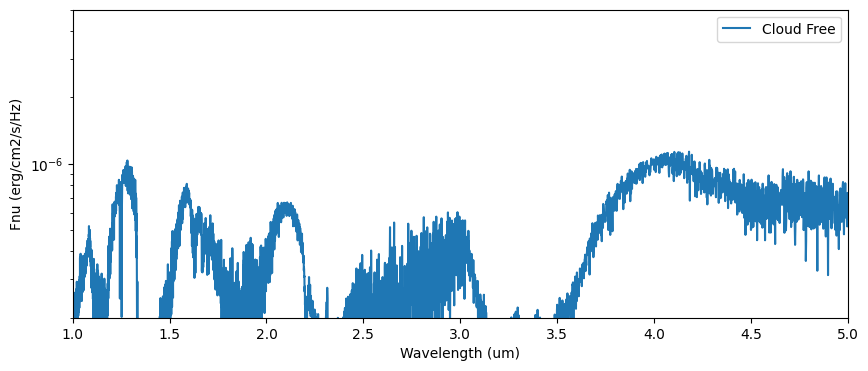

In [21]:
# show cld free spectrum
plt.figure(figsize=(10,4))
plt.plot(x_cld_free, y_cld_free, label='Cloud Free')
plt.xlim(1, 5)
plt.ylim(2e-7, 0.5e-5)
plt.yscale('log')
plt.xlabel('Wavelength (um)')
plt.ylabel('Fnu (erg/cm2/s/Hz)')
plt.legend();

In [43]:
# compute cloudy spectrum
directory = f'{ref}/virga/'
# we can get the same full output from the virga run
cld_species = ['MgSiO3', 'Mg2SiO4', "Fe"]
fseds = [1, 2, 4, 8]
cld_out = {}
for fsed in fseds:
    bd = pj.inputs(calculation='browndwarf')
    Teff = 1300
    bd.gravity(gravity=1000, gravity_unit=u.Unit('m/s**2'))
    bd.phase_angle(0)
    # prepare atmosphere pt and chemistry
    ptfile = f"{homedir}/uoedrive/data/diamondback/tp_profiles/t1300g1000f{fsed}_m0.0_co1.0.pt"
    p_callie, t_callie = np.loadtxt(ptfile, usecols=[1,2], unpack=True, skiprows=2)
    bd.add_pt(t_callie, p_callie)
    bd.channon_grid_low(filename=os.path.join(os.environ.get('picaso_refdata'),'chemistry','visscher_abunds_m+0.0_co1.0' ))
    bd.inputs['atmosphere']['profile']['kz'] = [1e9]*len(p_callie)
    bd.virga(cld_species, directory, fsed=fsed, mh=1, mmw=2.2)

    cldy = bd.spectrum(opa, full_output=True)
    x_cldy, y_cldy = convert_unit(cldy, R=3000)
    cld_out[f'fsed{fsed}'] = cldy

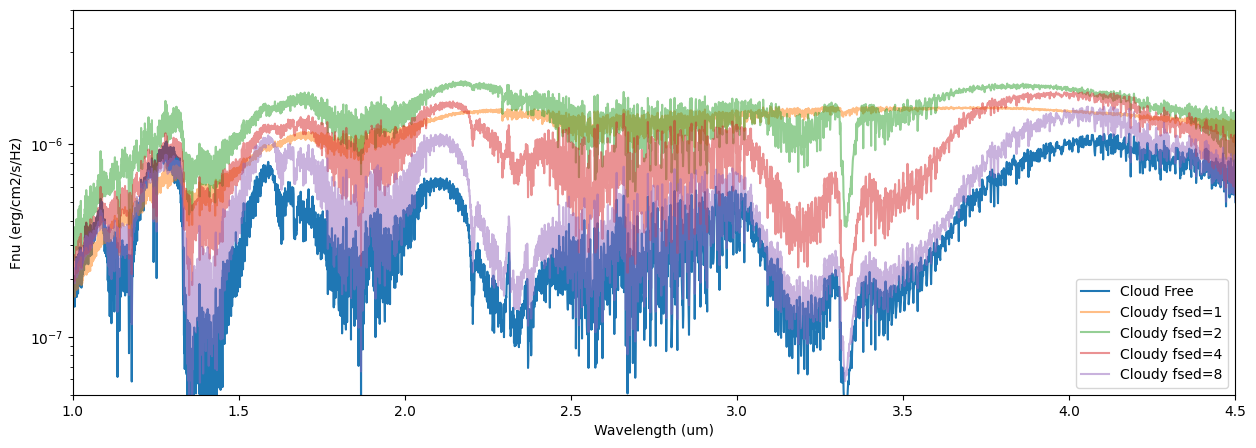

In [44]:
# show cldy spectrum
plt.figure(figsize=(15,5))
plt.plot(x_cld_free, y_cld_free, label='Cloud Free')
for fsed in fseds:
    plt.plot(cld_out[f'fsed{fsed}']['regridx'], cld_out[f'fsed{fsed}']['regridy'], 
             label=f'Cloudy fsed={fsed}', alpha=0.5)
plt.xlim(1, 4.5)
plt.ylim(0.5e-7, 0.5e-5)
plt.yscale('log')
plt.xlabel('Wavelength (um)')
plt.ylabel('Fnu (erg/cm2/s/Hz)')
plt.legend();

In [11]:
import matplotlib as mpl
def extend_colormap(cmap, end_color, factor=0.2, n=100):
    """ Extend a colormap to include a darker end color gradually.
    cmap: colormap instance, e.g., cm.OrRd
    end_color: the color to extend to, e.g., 'darkred'
    factor: proportion of the colormap to be replaced by the extended color
    n: number of colors in the new colormap
    """
    original_colors = cmap(np.linspace(0, 1, n))
    end_color_rgba = np.array(mpl.colors.to_rgba(end_color))
    
    extended_colors = []
    for i in range(n):
        if i < n * (1 - factor):
            extended_colors.append(original_colors[i])
        else:
            blend = (i - n * (1 - factor)) / (n * factor)
            blended_color = (1 - blend) * original_colors[i] + blend * end_color_rgba
            extended_colors.append(blended_color)
    
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list('extended_cmap', extended_colors)
    return new_cmap

def truncate_colormap(cmap, min_val=0.0, max_val=1.0, n=100):
    """ Truncate a colormap.
    cmap: colormap instance, e.g., cm.gist_heat
    min_val: the lower bound of the new colormap
    max_val: the upper bound of the new colormap
    n: number of colors in the new colormap
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({},{:.2f},{:.2f})'.format(cmap.name, min_val, max_val),
        cmap(np.linspace(min_val, max_val, n)))
    return new_cmap

In [9]:
cfmax = 5.28e13

In [37]:
# cldy CF plot
def plot_cf(df, R=45000):
    import matplotlib.ticker as ticker
    from scipy.ndimage import gaussian_filter
    from scipy.signal import savgol_filter
    #cmap = truncate_colormap(plt.cm.OrRd, 0.0, 1) #plt.cm.gist_heat_r #Blues #gist_heat_r #hot_r
    cmap = extend_colormap(plt.cm.OrRd, (0.2, 0.0, 0.0, 1), factor=0.2)
    cmap.set_under('white', alpha=0)
    fig, ax, CF = picplt.thermal_contribution(
        df['full_output'], norm=picplt.colors.LogNorm(vmin=1e8, vmax=5e11), tau_max=1, R=R, cmap=cmap)
        #df['full_output'], norm=picplt.colors.LogNorm(vmin=cfmax/1e3, vmax=cfmax), tau_max=1, R=R, cmap=cmap)

    y = []
    CF_scaled = np.empty_like(CF)
    for wav in np.arange(0, CF.shape[1], 1):
        y.append(p_callie[np.argmax(CF[:,wav])])
        CF_scaled[:, wav] = CF[:,wav]/np.nansum(CF[:,wav])
    x, _ = pj.mean_regrid(df['wavelength'], df['thermal'], R=R)
    y = np.array(y[::-1])
    #ax.plot(x, gaussian_filter(savgol_filter(y, 101, 1), 20), '--', color='white', linewidth=1.5)
    ax.plot(x, gaussian_filter(savgol_filter(y, 5, 1), 1), '--', color='white', linewidth=1.5)
    #ax.plot(x, gaussian_filter(y, 1), '--', color='white', linewidth=1.5)
    #ax.plot(x, y, '--', color='white', linewidth=1.5)

    ax.set_ylim(0.5e2, 1e-2)
    ax.set_xlim(1, 5)
    ax.set_xscale('log')
    #ax.set_xticks(np.arange(1, 6), labels=[f'{i:.1f}' for i in np.arange(1, 6)])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.xaxis.set_major_formatter('{x:.1f}')
    ax.xaxis.set_tick_params(labelsize=17)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    #ax.axvspan(1.51, 1.81, alpha=0.2, color='tab:blue', label="H")
    #ax.axvspan(1.95, 2.48, alpha=0.2, color='tab:blue', label="K")
    print(f'cfmax = {CF.max():.2e}')
    return CF, CF_scaled

In [13]:
wls = np.array([1.01260614, 1.02729332, 1.04231226, 1.05766058, 1.07333553,
       1.08933425, 1.10564828, 1.12227023, 1.13919115, 1.15640259,
       1.17389297, 1.1916517 , 1.20966506, 1.22791994, 1.2464031 ,
       1.26509893, 1.28399253, 1.30306756, 1.32230067, 1.34168315,
       1.36120081, 1.38083816, 1.40057969, 1.42041063, 1.4403168 ,
       1.46028388, 1.48029876, 1.50034833, 1.52042079, 1.54050517,
       1.56059527, 1.58067572, 1.60073698, 1.6207701 , 1.64076734,
       1.66072059, 1.68062341, 1.70046937, 1.72025263, 1.73996794,
       1.75961077, 1.77917421, 1.79865038, 1.81804252, 1.83734775,
       1.85656381, 1.87568784, 1.89471817, 1.91365302, 1.93249071,
       1.95123041, 1.96987092, 1.9884119 , 2.00685167, 2.02518272,
       2.04341173, 2.06153917, 2.07956553, 2.0974915 , 2.11531591,
       2.13303995, 2.15066385, 2.16818833, 2.18561316, 2.20293975,
       2.22016788, 2.2372992 , 2.25434446, 2.27129984, 2.28816009,
       2.30492544, 2.32159758, 2.3381772 , 2.35466456, 2.37106061,
       2.38736677, 2.40358448, 2.41971326, 2.43575501, 2.45171022,
       2.46758008, 2.48336148, 2.49904966, 2.51465559, 2.53018045,
       2.54562426, 2.56098819, 2.57627368, 2.59148073, 2.60661125,
       2.62166548, 2.63664412, 2.65154886, 2.66637969, 2.6811378 ,
       2.69582415, 2.71043921, 2.724998  , 2.73949099, 2.75391483,
       2.76827073, 2.78255939, 2.79678106, 2.8109374 , 2.82502818,
       2.83905482, 2.85301781, 2.86691809, 2.8807559 , 2.89453197,
       2.90824771, 2.92190313, 2.93549871, 2.94903493, 2.96250534,
       2.97591734, 2.98927259, 3.0025723 , 3.01581573, 3.02900434,
       3.04213858, 3.05521894, 3.06824589, 3.08121967, 3.0941422 ,
       3.10701251, 3.11983156, 3.13260078, 3.14531946, 3.15798831,
       3.17060876, 3.18318033, 3.19570303, 3.20817804, 3.22060633,
       3.23298764, 3.2453227 , 3.25761223, 3.26985669, 3.28205609,
       3.29421091, 3.3063221 , 3.31838942, 3.3304143 , 3.34239578,
       3.35433531, 3.36623263, 3.37808871, 3.38990355, 3.40167737,
       3.41341138, 3.42510915, 3.43677139, 3.44839358, 3.45997739,
       3.47152209, 3.48302913, 3.4944973 , 3.50592875, 3.51732254,
       3.52867937, 3.53999949, 3.55128336, 3.56253052, 3.57374239,
       3.58491898, 3.59606051, 3.60716748, 3.61823916, 3.62927699,
       3.64028096, 3.65125155, 3.66218305, 3.67307997, 3.68394399,
       3.69477582, 3.70557475, 3.71634221, 3.72707796, 3.737782  ,
       3.74845457, 3.75909615, 3.7697072 , 3.78028798, 3.79083824,
       3.80135846, 3.81184888, 3.82230997, 3.8327415 , 3.84314346,
       3.85351706, 3.8638618 , 3.87417841, 3.88446617, 3.89472342,
       3.90495038, 3.91514969, 3.92532158, 3.93546677, 3.94558454,
       3.9556756 , 3.96573973, 3.97577786, 3.98578954, 3.99577475,
       4.00573492, 4.01566887, 4.02557755, 4.03546047, 4.0453186 ,
       4.05515194, 4.06496   , 4.07474422, 4.08450317, 4.0942378 ,
       4.10394907, 4.11363554, 4.12329865, 4.13294125, 4.14256144,
       4.15215778, 4.16173077, 4.17128086, 4.18080807, 4.19031239,
       4.19979382, 4.20925331, 4.21868992, 4.22810507, 4.23749781,
       4.24686861, 4.256217  , 4.26554441, 4.27485037, 4.28413534,
       4.29339838, 4.30264091, 4.31186199, 4.32106256, 4.33024216,
       4.33940125, 4.34854031, 4.35765839, 4.36676073, 4.375844  ,
       4.38490772, 4.39395046, 4.40297413, 4.41197872, 4.42096329,
       4.42992783, 4.43887377, 4.44780016, 4.45670748, 4.4655962 ,
       4.47446585, 4.48331642, 4.49214888, 4.50096226, 4.509758  ,
       4.51853466, 4.52729321, 4.53603363, 4.54475641, 4.5534606 ,
       4.56214762, 4.57081652, 4.57946777, 4.58810139, 4.59671783,
       4.60531378, 4.61389256, 4.62245464, 4.63099957, 4.63952732,
       4.64803791, 4.65653229, 4.6650095 , 4.67347097, 4.68191528,
       4.69034338, 4.69875479, 4.70715046, 4.71552944, 4.72389317,
       4.73223972, 4.74057102, 4.74888659, 4.75718594, 4.76547003,
       4.77373838, 4.781991  , 4.79022884, 4.79845142, 4.80665779,
       4.81484985, 4.8230257 , 4.83118725, 4.83933401, 4.84746599,
       4.85558271, 4.86368513, 4.87177229, 4.87984514, 4.88790369,
       4.89594793, 4.90397739, 4.91199255, 4.9199934 , 4.92797995,
       4.93595219, 4.94391108, 4.95185566, 4.95978642, 4.96770239,
       4.97560549, 4.98349476, 4.9913702 , 4.99923182])
wls.shape

(319,)

In [14]:
clusters = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=np.float32)
clusters.shape

(319,)

cfmax = 4.60e+11


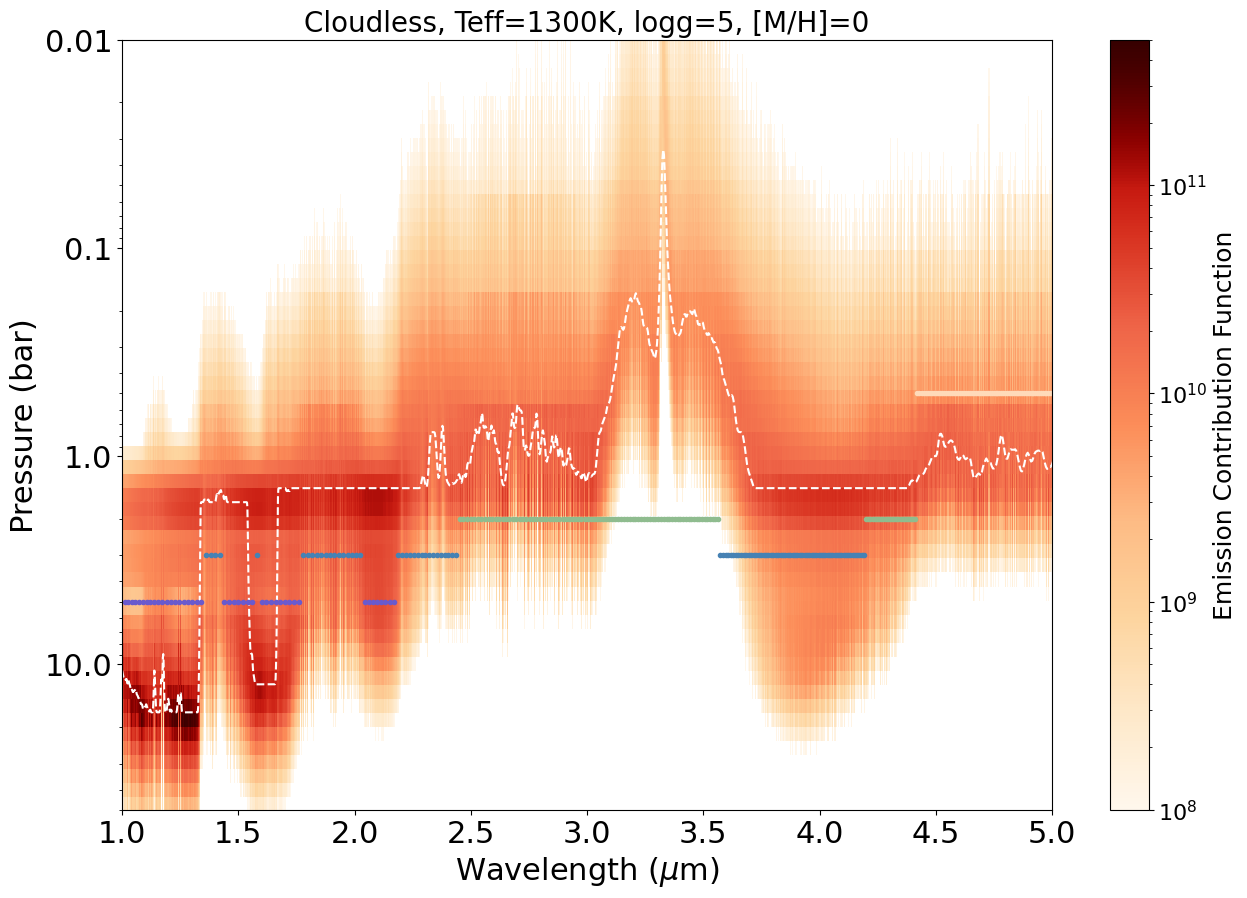

In [45]:
cf, cf_scaled = plot_cf(cld_free, R=1000)
#plt.text(1.6, 3., "H", color="white", fontsize=20)
#plt.text(2.15, 2., "K", color="white", fontsize=20)
#plt.text(1.71, 42, "H", color="darkslategrey", fontsize=20)
#plt.text(2.36, 42, "K", color="darkslategrey", fontsize=20)
ind0 = np.where(clusters==0)[0]
ind1 = np.where(clusters==1)[0]
ind2 = np.where(clusters==2)[0]
ind3 = np.where(clusters==3)[0]
plt.plot(wls[ind0], clusters[ind0]+5., '.', color='slateblue')
plt.plot(wls[ind1], clusters[ind1]+2., '.', color='steelblue')
plt.plot(wls[ind2], clusters[ind2]+0., '.', color='darkseagreen')
plt.plot(wls[ind3], clusters[ind3]-2.5, '.', color='peachpuff')
plt.title(f"Cloudless, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20})
plt.xticks([1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5],fontsize=22)
plt.xscale('linear')
plt.yticks(fontsize=22)
plt.xlabel("Wavelength ($\mu$m)", fontsize=22)
plt.ylabel("Pressure (bar)", fontsize=22)

plt.savefig('cf_nrs.png', dpi=200, bbox_inches='tight', transparent=True);

cfmax = 5.03e+11


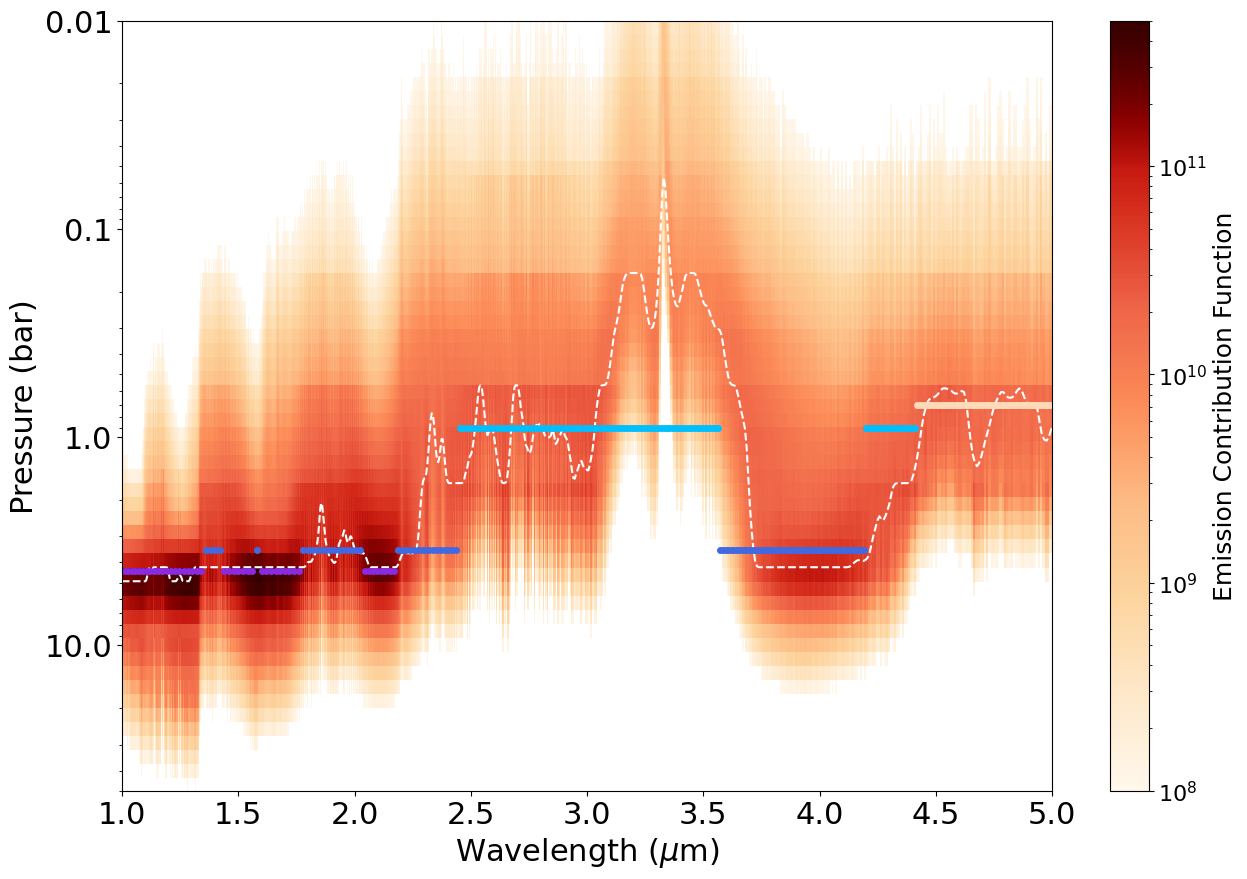

In [57]:
cf, cf_scaled = plot_cf(cld_out['fsed8'], R=500)
#plt.text(1.6, 3., "H", color="white", fontsize=20)
#plt.text(2.15, 2., "K", color="white", fontsize=20)
#plt.text(1.71, 42, "H", color="darkslategrey", fontsize=20)
#plt.text(2.36, 42, "K", color="darkslategrey", fontsize=20)
ms = 8
ind0 = np.where(clusters==0)[0]
ind1 = np.where(clusters==1)[0]
ind2 = np.where(clusters==2)[0]
ind3 = np.where(clusters==3)[0]
plt.plot(wls[ind0], 4.4*np.ones_like(wls[ind0]), '.', ms=ms, color='blueviolet')
plt.plot(wls[ind1], 3.5*np.ones_like(wls[ind1]), '.', ms=ms, color='royalblue')
plt.plot(wls[ind2], 0.9*np.ones_like(wls[ind2]), '.', ms=ms, color='deepskyblue')
plt.plot(wls[ind3], 0.7*np.ones_like(wls[ind3]), '.', ms=ms, color='peachpuff')
#plt.title(f"Cloudless, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20})
plt.xticks([1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5],fontsize=22)
plt.xscale('linear')
plt.yticks(fontsize=22)
plt.xlabel("Wavelength ($\mu$m)", fontsize=22)
plt.ylabel("Pressure (bar)", fontsize=22)

plt.savefig('cf_nrs.png', dpi=200, bbox_inches='tight', transparent=True);

cfmax = 3.63e+11


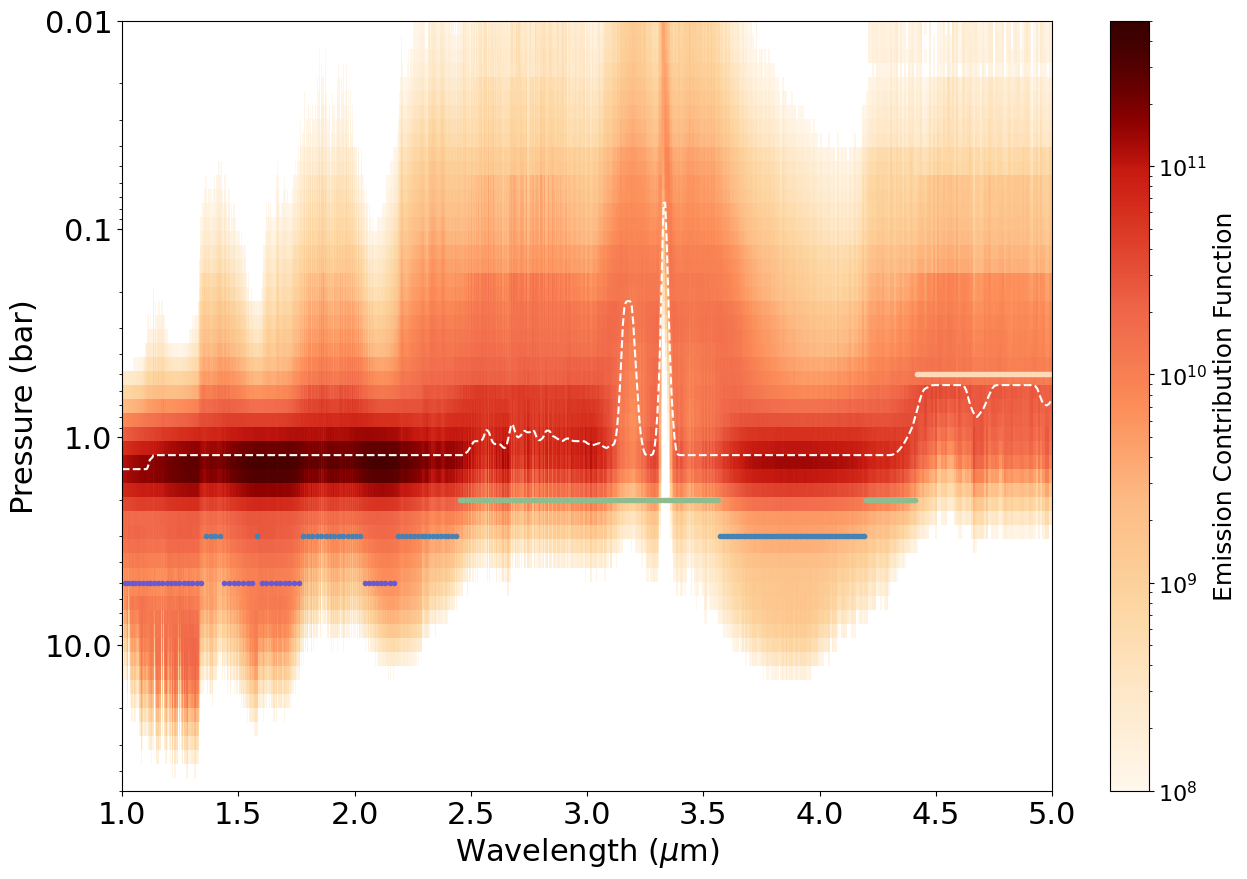

In [47]:
cf, cf_scaled = plot_cf(cld_out['fsed4'], R=500)
#plt.text(1.6, 3., "H", color="white", fontsize=20)
#plt.text(2.15, 2., "K", color="white", fontsize=20)
#plt.text(1.71, 42, "H", color="darkslategrey", fontsize=20)
#plt.text(2.36, 42, "K", color="darkslategrey", fontsize=20)
ind0 = np.where(clusters==0)[0]
ind1 = np.where(clusters==1)[0]
ind2 = np.where(clusters==2)[0]
ind3 = np.where(clusters==3)[0]
plt.plot(wls[ind0], clusters[ind0]+5., '.', color='slateblue')
plt.plot(wls[ind1], clusters[ind1]+2., '.', color='steelblue')
plt.plot(wls[ind2], clusters[ind2]+0., '.', color='darkseagreen')
plt.plot(wls[ind3], clusters[ind3]-2.5, '.', color='peachpuff')
#plt.title(f"Cloudless, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20})
plt.xticks([1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5],fontsize=22)
plt.xscale('linear')
plt.yticks(fontsize=22)
plt.xlabel("Wavelength ($\mu$m)", fontsize=22)
plt.ylabel("Pressure (bar)", fontsize=22)

plt.savefig('cf_nrs.png', dpi=200, bbox_inches='tight', transparent=True);

In [25]:
wls = np.array(wls)
clusters = np.array(clusters)

cfmax = 5.28e+13


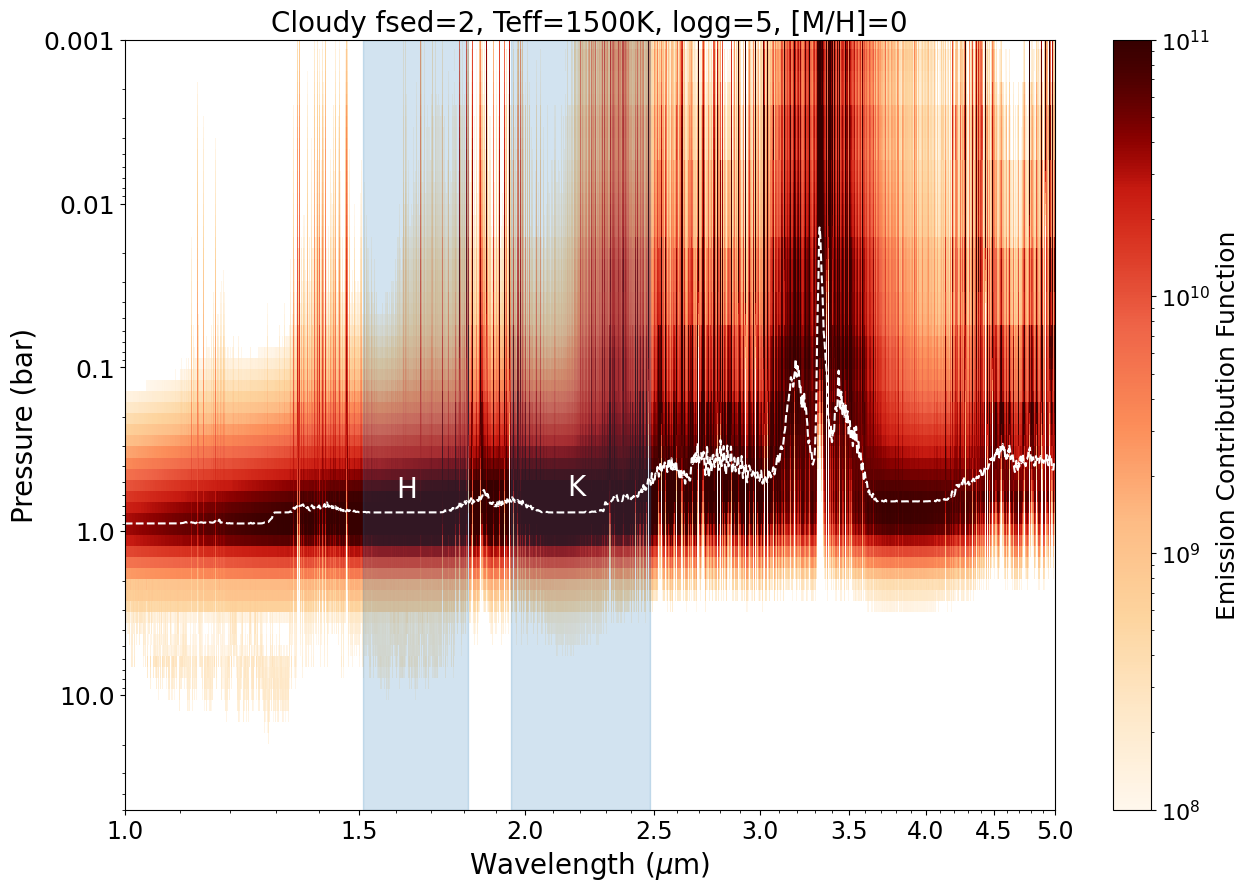

In [8]:
cf_cldy, cf_cldy_scaled = plot_cf(cld_out['fsed2'])
plt.text(1.6, 0.62, "H", color="white", fontsize=20)
plt.text(2.15, 0.6, "K", color="white", fontsize=20)
plt.title(f"Cloudy fsed=2, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20})
plt.savefig('cf_cldy_fsed2.png', dpi=200, bbox_inches='tight', transparent=True);

cfmax = 5.28e+13


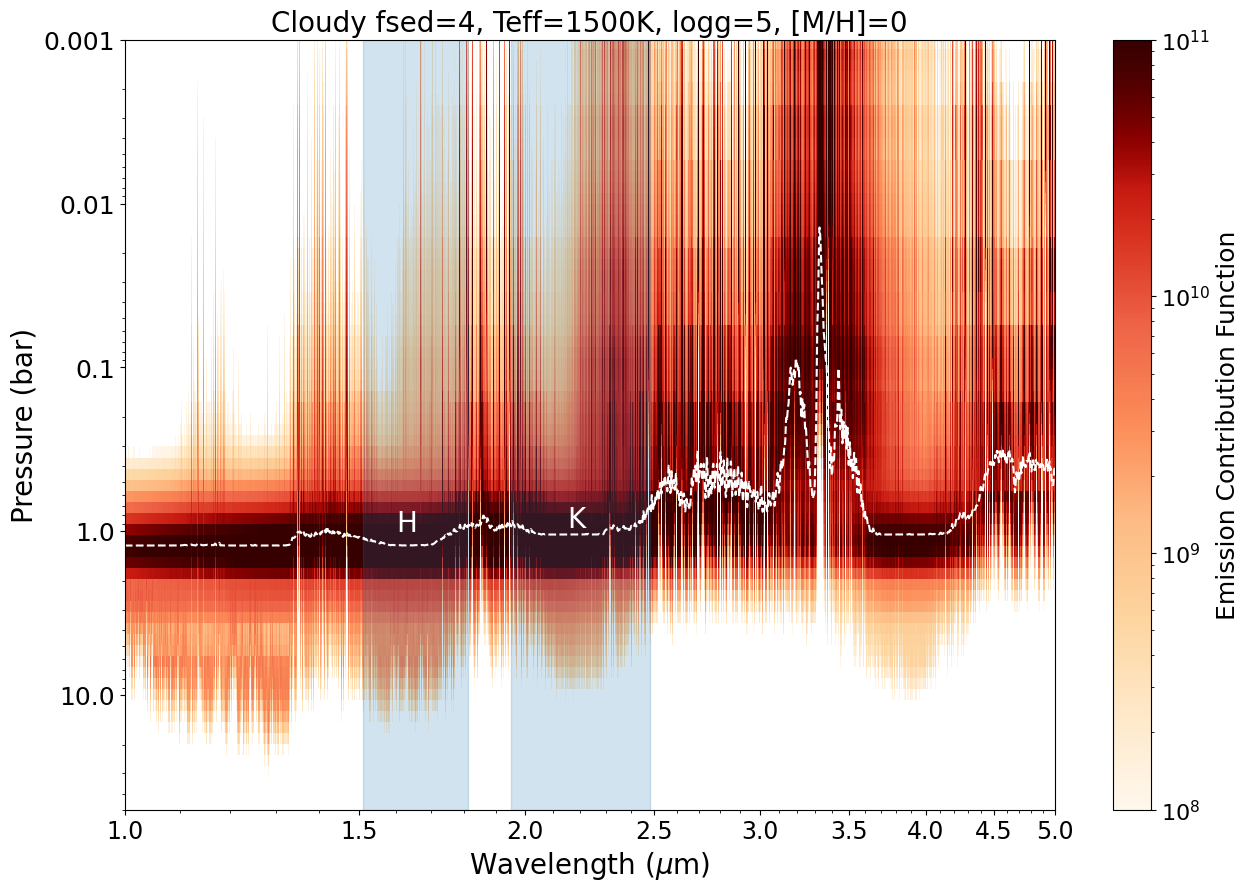

In [25]:
cf_cldy, cf_cldy_scaled = plot_cf(cld_out['fsed4'])
plt.text(1.6, 1., "H", color="white", fontsize=20)
plt.text(2.15, 0.95, "K", color="white", fontsize=20)
plt.title(f"Cloudy fsed=4, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20});

cfmax = 5.28e+13


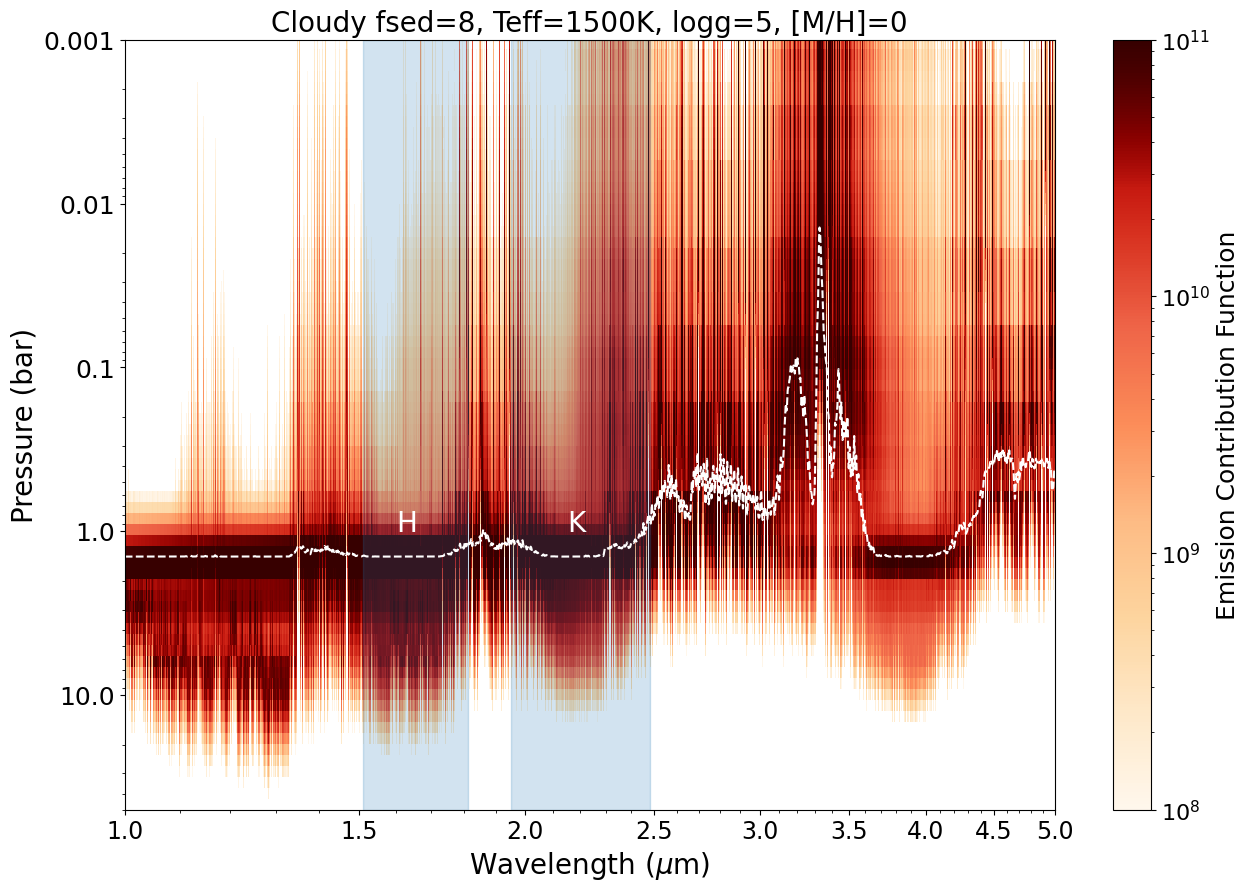

In [26]:
cf_cldy, cf_cldy_scaled = plot_cf(cld_out['fsed8'])
plt.text(1.6, 1, "H", color="white", fontsize=20)
plt.text(2.15, 1, "K", color="white", fontsize=20)
plt.title(f"Cloudy fsed=8, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20});

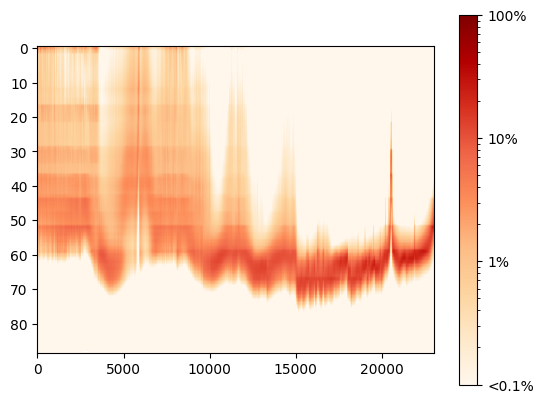

In [58]:
plt.imshow(cf_scaled, aspect=200, norm=picplt.colors.LogNorm(vmin=1e-3, vmax=1), cmap=plt.cm.OrRd)
cbar = plt.colorbar()
cbar.set_ticks([1e-3, 1e-2, 1e-1, 1])
cbar.set_ticklabels(['<0.1%', '1%', '10%', '100%'])

In [28]:
# show condensates
from bokeh.io import output_notebook
output_notebook()
recommended = vj.recommend_gas(p_callie, t_callie, metallicity, mean_molecular_weight, plot=True, height=400, width=600,)

Loading BokehJS ...

In [10]:
!pip freeze

aesara-theano-fallback==0.1.0
alabaster==0.7.16
appnope==0.1.4
arviz==0.12.1
astropy==5.3.4
asttokens==2.4.1
Babel==2.15.0
beautifulsoup4==4.12.3
bibtexparser==1.4.1
bleach==6.1.0
bokeh==2.4.3
cachetools==5.3.3
Cartopy==0.22.0
certifi==2024.7.4
cftime==1.6.4
charset-normalizer==3.3.2
colorcet==3.1.0
comm==0.2.2
contourpy==1.2.1
corner==2.2.2
cycler==0.12.1
debugpy==1.8.2
decorator==5.1.1
deprecat==2.1.1
dill==0.3.8
docutils==0.21.2
dynesty==2.1.4
emcee==3.1.0
exceptiongroup==1.2.1
executing==2.0.1
exoplanet==0.5.3
exoplanet_core==0.1.2
fastprogress==1.0.3
filelock==3.15.4
fonttools==4.53.1
h5netcdf==1.3.0
h5py==3.11.0
holoviews==1.17.1
idna==3.7
imagesize==1.4.1
importlib_metadata==8.0.0
importlib_resources==6.4.0
ipykernel==6.29.5
ipython==8.18.1
jedi==0.19.1
Jinja2==3.1.2
joblib==1.4.2
jupyter_client==8.6.2
jupyter_core==5.7.2
kiwisolver==1.4.5
llvmlite==0.43.0
Markdown==3.6
MarkupSafe==2.1.5
matplotlib==3.7.2
matplotlib-inline==0.1.7
nest-asyncio==1.6.0
netCDF4==1.6.0
numba==0.60.0
